To Do:
1. add hyperlinks for sections


### Which not-for-profits might be at the highest risk for fraud?  For not-for-profits, this often happens through contractor payments.

1. Employees/Volunteers/Voting Members as a percentage of over 100K contractors
    - Employees/Volunteers/Voting Members count / count of contractors over 100K
    - fewer employees can translate to weaker controls over vetting and payment of contractors

1. Count of contractors as a percentage of total expenses
    - count of contractors / total expenses
    - this will help identify a larger number of contractors paid a similar amount
    - the larger this number the larger the distribution of expenses accross contractors


*************************
1.  Small number of voting members and independent voting members compared to revenue
    - this could be indicative of low oversight of the organization
    - dataset also includes independent vs. non-independent voting members, unsure about specific differences
1. Salaries expense as a percentage of revenue
    - not-for-profit management could be paying themselves a disproportionate salary
    
1.  Small number of staff members compared to the volume of money raised
    - employee count / current year revenue
    - fewer employees can translate to weaker internal financial controls.


younger organizations vs older organizations


### Data source:
https://www.open990.org/catalog/, this company provides raw data for free, however they also provide analytics services for a charge https://appliednonprofitresearch.com/customdata/

overview of data provided by open990
https://medium.com/@open990/the-irs-990-e-file-dataset-getting-to-the-chocolatey-center-of-data-deliciousness-90f66097a600

This dataset has great documentation about what the attributes mean, however this only includes data for 1 year(2016).

### Not-for-profit info to inform my process
https://en.wikipedia.org/wiki/501(c)_organization - there are many different types of 501(c) orgs, each type is organized around a specific category of activity, labor, social and recreational, business leagues, ect.

__501(c)(3) categories of activity__ - Religious, Educational, Charitable, Scientific, Literary, Testing for Public Safety, to Foster National or International Amateur Sports Competition, or Prevention of Cruelty to Children or Animals Organizations

https://nonprofitrisk.org/resources/articles/a-violation-of-trust-fraud-risk-in-nonprofit-organizations/

One area in which nonprofit organizations seem particularly vulnerable is billing schemes, in which an employee fraudulently submits invoices to obtain payments he or she is not entitled to receive. According to the most recent ACFE survey, billing schemes were among the most common fraud methods in the cases studied for the 2012 report.

Billing schemes often involve the creation of a shell company. In such a fraud, a dishonest employee sets up a fake identity that bills for good or services the organization does not receive. In some instances, goods or services may be delivered but are marked up excessively, with the proceeds diverted to the employee.


In [176]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil

In [2]:
df = pd.read_csv('data/Open990_Contractor_Compensation_Snack_Set_Public_2019-01-24.csv',
                 encoding = 'unicode_escape',
                 engine='python')

### Pre-Processing Steps
1. limit data to only orgs with contractor payments in excess of 100K
1. refine categories of non-profit mission/purpose statements
    - completing this task in *990_mission_statement* notebook.

1. convert NaN values into False
    - for many boolean fields in the 990, the absense of a response is interpreted as NaN, converting these to False will allow for a machine readable format. 
1. format target variable for machine learning algorithems to make predictions on
    - somewhere around 10% of the dataset
    
*************************
#### Additional Considerations
1. refine categories of services being provided to the orgs
    - there is probably a high level of inconsistency here
    - this will require a summarization process similar to what I'm doing for the mission statement of the orgs
    - is there a relationship between the size and type of org and the types of services paid for?


In [3]:
# how large is the full dataset?
df.shape

(237448, 110)

In [4]:
# examine columns in full dataset
df.head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,doing_business_as,phone,website,address,city,state,country,zip,org_form.corp,org_form.trust,org_form.association,org_form.other_form,org_form.other_form_desc,formation_yr,grp_exempt_num,state_legaldomicile,grp_return,grp_subs_all_incl,exempt_status.501c3,exempt_status.501c_any,exempt_status.501c_txt,gross_receipts,discontinue_dispose25,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string
0,10018927,AMERICAN LEGION POST 5 BOURQUE-LANIGAN,2016-01-01,2016-12-31,2016,AMERICAN LEGION POST 5,+1 (207) 872-8824,WTVLLEGION.ORG,21 COLLEGE AVENUE,WATERVILLE,ME,NaN,04901,True,NaN,NaN,NaN,NaN,1926.0,925.0,ME,no,NaN,NaN,True,19.0,501808,NaN,9,9,8,0.0,0,0.0,11458.0,0.0,983.0,137239.0,149680.0,0.0,20120.0,61034.0,0.0,0,113034.0,194188.0,-44508.0,595704.0,29618.0,566086.0,12549,0,1036,128465,142050,0,22141,62171,0,100057,184369,-42319,561928,38161,523767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,010018927_201612,2016v3.0,201721359349307007,NzM0MjczMTQ5MzAyOTkxNjA2NQ
1,10018930,AMERICAN LEGION - MAINE DEPARTMENT,2015-05-01,2016-04-30,2016,NaN,+1 (207) 873-3229,WWW.MAINELEGION.ORG,PO BOX 900,WINSLOW,ME,NaN,049010727,True,NaN,NaN,NaN,NaN,1919.0,NaN,ME,no,NaN,NaN,True,19.0,784286,NaN,60,56,10,NaN,0,NaN,488958.0,214498.0,2452.0,62279.0,768187.0,3500.0,NaN,263411.0,NaN,0,518288.0,785199.0,-17012.0,941168.0,364115.0,577053.0,487889,210898,1613,83886,784286,4500,0,245792,0,482665,732957,51329,995802,367420,628382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,010018930_201604,2015v2.1,201622149349301207,NjA2ODIzMDg0NzYyMzA2MDM2NA
2,10019705,Ancient Free and Accepted Masons of Maine Gran...,2015-04-01,2016-03-31,2016,NaN,+1 (207) 358-3110,www.mainemason.org,P O Box 430,Holden,ME,NaN,044290430,True,NaN,NaN,NaN,NaN,1820.0,275.0,ME,no,NaN,NaN,True,10.0,362909,NaN,11,9,5,0.0,0,0.0,1837.0,321565.0,29073.0,1972.0,354447.0,0.0,0.0,78522.0,0.0,0,236707.0,315229.0,39218.0,1704310.0,0.0,1704310.0,1402,315455,29298,-13191,332964,18061,0,86383,0,241884,346328,-13364,1640608,0,1640608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [595]:
# find count of null values
# for each column
# (df.isna().sum()/df.isna().count()) * 100

In [6]:
# remove periods from column names
df.columns = df.columns.str.replace('.', '_')

### Limit dataset to only orgs with payments to contractors over 100K
since there is some inconsistency in the contractor information I will use the absence of a payment amount to contractor #1 as evidence that the org has not paid a contractor in excess of $100K

In [597]:
# identify columns
for c in df.columns:
    if 'contractor_1' in c:
        print(c)       

name_contractor_1
address_contractor_1
city_contractor_1
state_contractor_1
zip_contractor_1
country_contractor_1
services_contractor_1
amt_paid_contractor_1
contractor_100k_ct


In [8]:
df[~df.amt_paid_contractor_1.isnull()].shape

(30345, 110)

In [99]:
# orgs that did not pay over 100K in contractor compensation
df[~(df.amt_paid_contractor_1 > 100000)].loc[:,'amt_paid_contractor_1'].value_counts(dropna=False)

NaN         207103
0.0              7
100000.0         7
60000.0          4
2500.0           3
             ...  
60970.0          1
3813.0           1
89950.0          1
90000.0          1
7200.0           1
Name: amt_paid_contractor_1, Length: 141, dtype: int64

In [103]:
# drop orgs that received less than 100K in contractor compensation
df.drop(df[~(df.amt_paid_contractor_1 > 100000)].index, inplace=True)

In [104]:
df.shape

(30185, 110)

#### Remove inconsistencies between contractor_100k_ct column and amt_paid_contractor_1 column

In [110]:
# 10 orgs with contractor payments over 100K
# stated that their count of contractors was null
df.loc[df['contractor_100k_ct'].isnull(), 'contractor_100k_ct'].shape

(10,)

In [111]:
# I will fill with 1
df.loc[df['contractor_100k_ct'].isnull(), 'contractor_100k_ct'] = 1

In [115]:
df.loc[df['contractor_100k_ct'].isnull(), 'contractor_100k_ct'].shape

(0,)

In [112]:
# 44 orgs with contractor payments over 100K
# stated that their count of contractors was 0
df.loc[df['contractor_100k_ct'] == 0, 'contractor_100k_ct'].shape

(44,)

In [113]:
# in these cases fill in 1 in the contractor_100k_ct
df.loc[df['contractor_100k_ct'] == 0, 'contractor_100k_ct'] = 1

In [165]:
df.loc[df['contractor_100k_ct'] == 0, 'contractor_100k_ct'].shape

(0,)

###  Data Preprocessing

In [117]:
# fill na for financial data
# fill nans with 0 so that I can perform math on these amounts
# when amounts are left blank on the tax return they show up here as NaN

for column in list(df.loc[:,'income_tot_unrelated' : 'asset_net_endyr'].columns):
    df[column].fillna(0, inplace=True)

In [118]:
# for voting_memb_ct, voting_indepmemb_ct, employee_tot_ct, volunteer_tot_ct
# fill nans with 0 so that I can perform math on these amounts

for column in list(df.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns):
    df[column].fillna(0, inplace=True)

In [168]:
# this column contains all other 
# subcategories of 501 orgs
# by adding 3, I can have all 501 information in one column
df['exempt_status_501c_txt'].fillna(3, inplace=True)

# convert data type of 501 type to int from float
df.exempt_status_501c_txt = df.exempt_status_501c_txt.apply(int)

In [125]:
# for org_forms
# fill nans with False

for column in list(df.loc[:,'org_form_corp' : 'org_form_other_form'].columns):
    df[column].fillna(False, inplace=True)

In [126]:
# formation year has a number of NaN values
# Convert these to None to be able to encode properly

df.loc[df.formation_yr.isna(), 'formation_yr'] = 'None'

In [267]:
# change format of formation_yr &
# exempt_status_501c_txt to string
# since the information in these columns
# doesn't have value as a continuous variable

df.formation_yr = df.formation_yr.apply(int).apply(str)

# also add underscore after digit 
# so that when I import this data into modeling 
# notebook, the format of object is preserved
df.exempt_status_501c_txt = df.exempt_status_501c_txt.apply(lambda x: str(x) + '_')

ValueError: invalid literal for int() with base 10: '1940.0'

In [278]:
# grp_return and exempt_status_501c3 are encoded as an object data type
# since it should be bool I will 
# format both into bool
df.grp_return = df.grp_return.apply(lambda x: True if x == 'yes' else False)
df.exempt_status_501c3 = df.exempt_status_501c3.apply(lambda x: True if x == True else False)

In [272]:
# change format of contractor count
# to int since it doesn't make sense for 
# ther to be a fractional contractor
df.contractor_100k_ct = df.contractor_100k_ct.apply(int)

In [152]:
# drop columns that are mostly null (greater than 60%)
# and that don't seem to contribute usefull information
(df.isnull().mean() * 100)[(df.isnull().mean() * 100) > 60]

doing_business_as           90.839821
country                     99.768097
org_form_other_form_desc    98.466126
grp_exempt_num              95.368561
grp_subs_all_incl           90.442273
exempt_status_501c_any      75.593838
discontinue_dispose25       99.148584
country_contractor_1        98.701342
country_contractor_2        99.102203
country_contractor_3        99.234719
name_contractor_4           60.993871
address_contractor_4        61.156203
city_contractor_4           61.179394
state_contractor_4          61.437800
zip_contractor_4            61.454365
country_contractor_4        99.390426
services_contractor_4       61.106510
amt_paid_contractor_4       60.997184
name_contractor_5           67.268511
address_contractor_5        67.391088
city_contractor_5           67.397714
state_contractor_5          67.593175
zip_contractor_5            67.639556
country_contractor_5        99.522942
services_contractor_5       67.364585
amt_paid_contractor_5       67.265198
dtype: float

In [159]:
# drop these 8 columns
(df.isnull().mean() * 100)[(df.isnull().mean() * 100) > 60][0:7]

doing_business_as           90.839821
country                     99.768097
org_form_other_form_desc    98.466126
grp_exempt_num              95.368561
grp_subs_all_incl           90.442273
exempt_status_501c_any      75.593838
discontinue_dispose25       99.148584
dtype: float64

In [161]:
# drop columns that are mostly null 
# and that don't seem to contribute usefull information
list((df.isnull().mean() * 100)[(df.isnull().mean() * 100) > 60][0:7].index)

['doing_business_as',
 'country',
 'org_form_other_form_desc',
 'grp_exempt_num',
 'grp_subs_all_incl',
 'exempt_status_501c_any',
 'discontinue_dispose25']

In [162]:
# drop columns that are mostly null and don't contribute useful information
df.drop(list((df.isnull().mean() * 100)[(df.isnull().mean() * 100) > 60][0:7].index), axis=1, inplace=True)

In [ ]:
# A number of organizations have no volunteers or employees
# drop organizations with no volunteers or employees



In [257]:
df.head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,phone,website,address,city,state,zip,org_form_corp,org_form_trust,org_form_association,org_form_other_form,formation_yr,state_legaldomicile,grp_return,exempt_status_501c3,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP
13,10056837,EASTERN MAINE ELECTRIC COOPERATIVE INC,2016-01-01,2016-12-31,2016,+1 (207) 454-7555,www.emec.com,PO Box 425,Calais,ME,046190425,True,False,False,False,1940,ME,no,NaN,12,15549792,11,11,37,0.0,0,0.0,0.0,15540869.0,280449.0,0.0,15821318.0,0.0,352726.0,1774024.0,0.0,0,13694568.0,15821318.0,0.0,39372255.0,26541056.0,12831199.0,0,15214173,335619,0,15549792,0,-242865,1753677,0,14038980,15549792,0,39367859,26785093,12582766,Lucas Tree Experts,PO Box 958,Portland,ME,04104,NaN,Tree Clearing Work,144757.0,Preti Flaherty Beliveau Pachios LLP,PO Box 9546,Portland,ME,04112,NaN,Legal,284923.0,On Target Utility Services,617 Water St,Gardiner,ME,04345,NaN,Utility Construction,526681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010056837_201612,2016v3.0,201722499349300607,NTk1ODY4MDk3ODk3NjYyMDY2OQ,0.081081,0.020501
17,10079380,CPORT CREDIT UNION,2016-01-01,2016-12-31,2016,+1 (207) 878-6200,WWW.CPORTCU.ORG,PO BOX 777,PORTLAND,ME,04104,True,False,False,False,1931,ME,no,NaN,14,9472036,9,8,81,8.0,52565,-75519.0,0.0,8093378.0,128192.0,162461.0,8384031.0,0.0,850819.0,3076199.0,0.0,0,3456770.0,7383788.0,1000243.0,173898488.0,157544120.0,16354368.0,0,9089872,158726,223438,9472036,0,752626,3404135,0,4052976,8209737,1262299,188534687,170915216,17619471,SYNERGENT,2 LEDGEVIEW DRIVE,WESTBROOK,ME,04092,NaN,CORE PROCESSING AND RELATED SERVICES,806186.0,SYSTEMS ENGINEERING,120 EXCHANGE STREET,PORTLAND,ME,04101,NaN,INFORMATION TECH. SERVICES,171160.0,PM SYSTEMS (ACI WORLDWIDE CORP),99944 COLLECTION CENTER DR,CHICAGO,IL,60693,NaN,ONLINE BANKING PROVIDER,147655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010079380_201612,2016v3.0,201713179349301261,NTAxNDUzNjQ4MzgwNDIzMTg2MA,0.033708,0.045678
27,10114035,Maine Education Association,2015-09-01,2016-08-31,2016,+1 (207) 622-5866,www.maine.nea.org,35 Community Drive,Augusta,ME,04330,True,False,False,False,1859,ME,no,NaN,5,8503978,21,19,53,200.0,16110,0.0,676851.0,7646167.0,31555.0,0.0,8354573.0,152815.0,0.0,

###  General Visualizations

(52.0, 0.0)

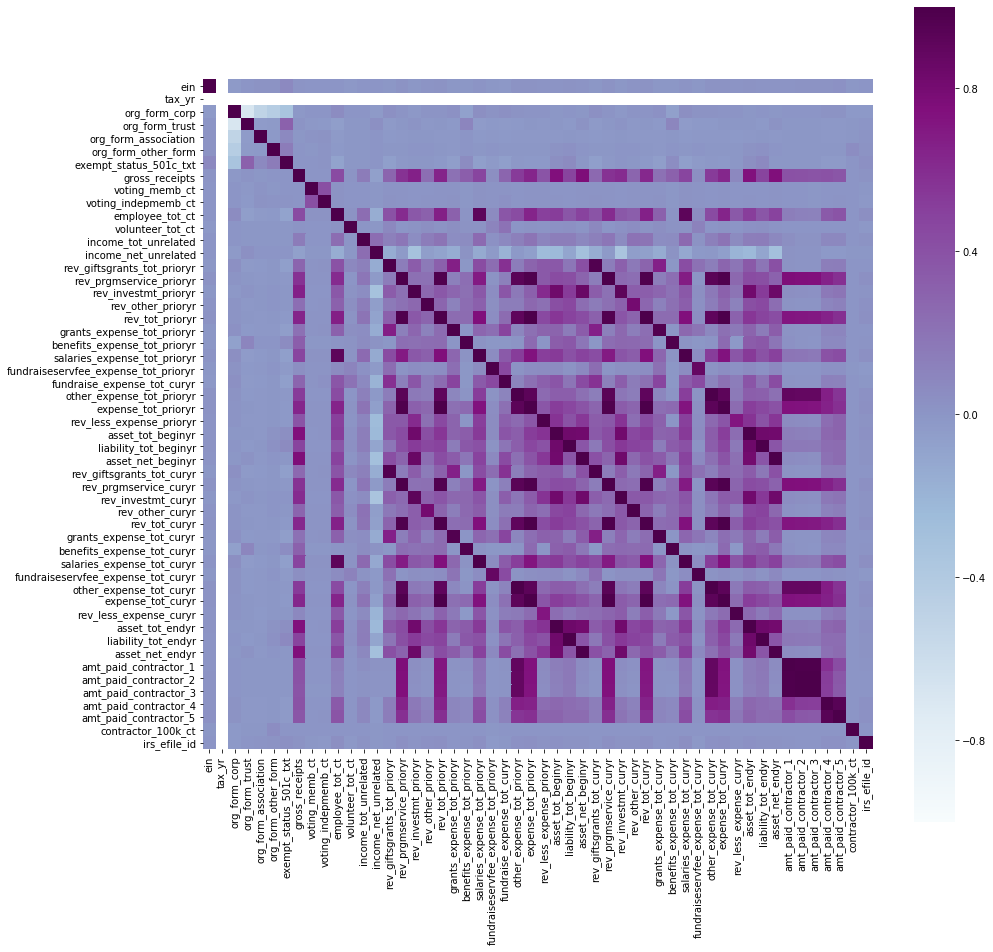

In [164]:
# compare features using a heatmap
plt.figure(figsize=(15, 15))

ax = sns.heatmap(df.corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, 
                 annot=False, 
                 cmap='BuPu')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#### Contractor Count Visualizations

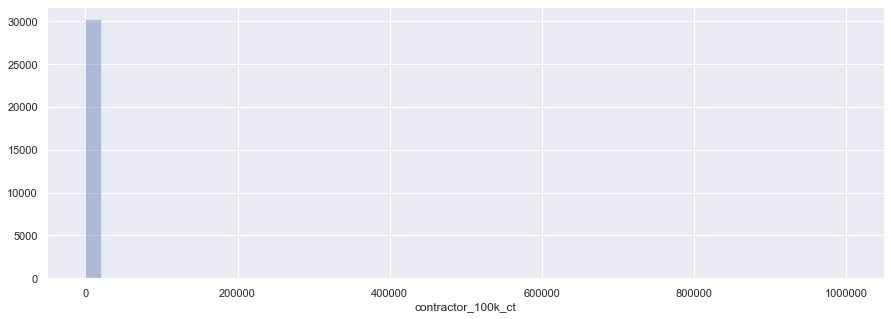

In [177]:
# what is the distribution of the count of contractors?
# there are some huge outliers
fig = plt.figure(figsize=(15, 5))

sns.distplot(df.contractor_100k_ct, bins=50, kde=False);

There are some huge outliers

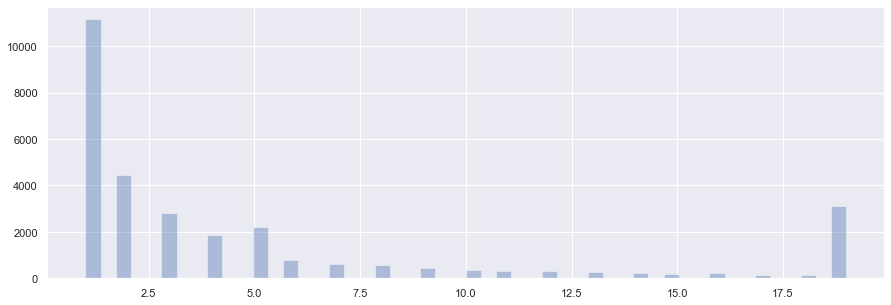

In [178]:
# what is the distribution of the count of contractors?
# there are some huge outliers
# excluding some of the outliers, I can see that this has a very long tail
fig = plt.figure(figsize=(15, 5))

sns.distplot(winsorize(df.contractor_100k_ct, (0,.1)), bins=50, kde=False);
#              sns.boxplot(winsorize(df['CON_CT_DIV_EMP_VOL_CT'], (0,.2)));

After removing some of the largest outliers, most organizations seem to only have 1 contractor that they paid over $100K

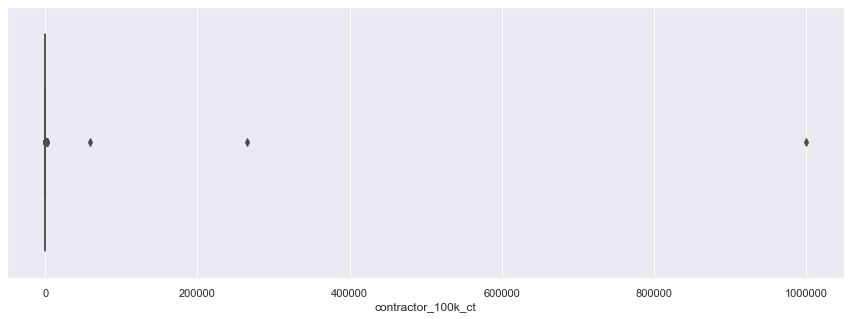

In [179]:
fig = plt.figure(figsize=(15, 5))

sns.boxplot(df.contractor_100k_ct);

#### Voting Members Visualizations

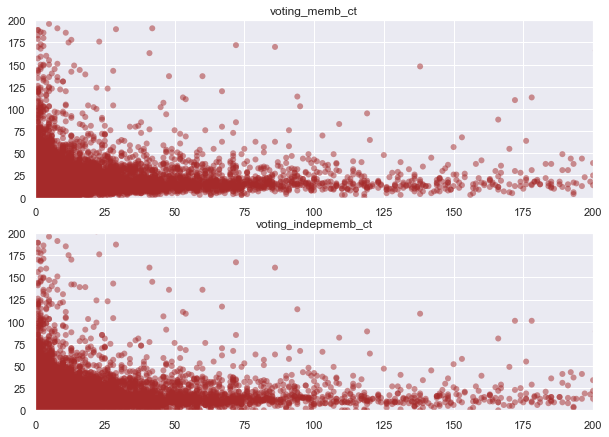

In [204]:
# graph employees against contractor count
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df.loc[:,'voting_memb_ct' : 'voting_indepmemb_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    ax = sns.scatterplot(df.contractor_100k_ct, df[column], color='brown', alpha=.5, edgecolor="none");
    ax.set_ylabel('')    
    ax.set_xlabel('')
    plt.xlim(0, 200)
    plt.ylim(0, 200)

As contractor count increase, the count of independent and non-independent voting members seems to increase only slightly.

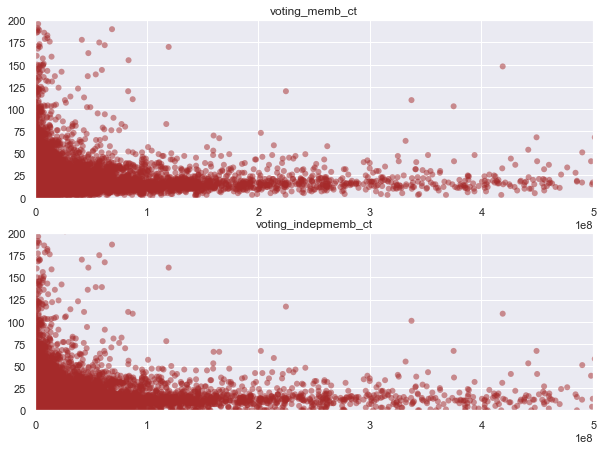

In [206]:
# graph employees against contractor count
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df.loc[:,'voting_memb_ct' : 'voting_indepmemb_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    ax = sns.scatterplot(df.salaries_expense_tot_curyr, df[column], color='brown', alpha=.5, edgecolor="none");
    ax.set_ylabel('')    
    ax.set_xlabel('')
    plt.xlim(0, 500000000)
    plt.ylim(0, 200)

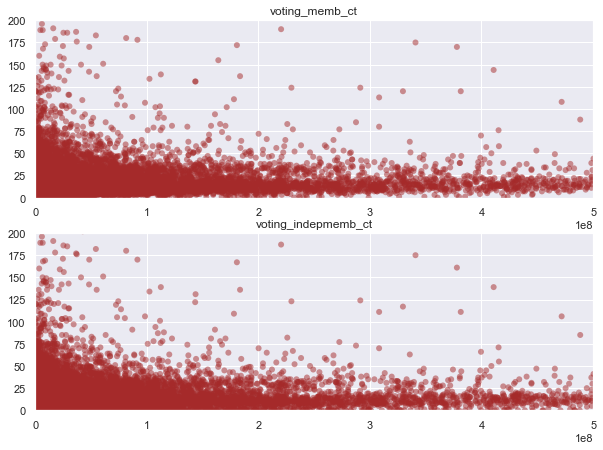

In [209]:
# graph employees against contractor count
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df.loc[:,'voting_memb_ct' : 'voting_indepmemb_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    ax = sns.scatterplot(df.gross_receipts, df[column], color='brown', alpha=.5, edgecolor="none");
    ax.set_ylabel('')    
    ax.set_xlabel('')
    plt.xlim(0, 500000000)
    plt.ylim(0, 200)

#### Employees and Volunteers Visualizations

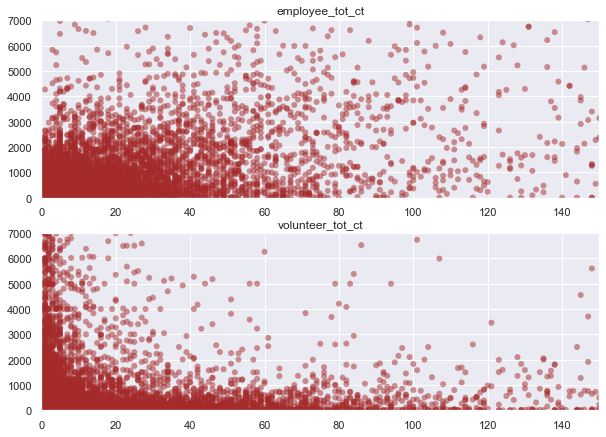

In [203]:
# graph employees against contractor count
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df.loc[:,'employee_tot_ct' : 'volunteer_tot_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    ax = sns.scatterplot(df.contractor_100k_ct, df[column], color='brown', alpha=.5, edgecolor="none");
    ax.set_ylabel('')    
    ax.set_xlabel('')
    plt.xlim(0, 150)
    plt.ylim(0, 7000)

For orgs with less than 50 contractors, count of contractors and employees is a positive relationship, while count of contractors and volunteers is an inverse relationship. 

For orgs with more than 50 contractors, volunteers are more prevalent than employees.  This seems to pose a potential risk to me since the work quality of volunteers might not be that of employees, which could create more risk for vendor payment fraud.

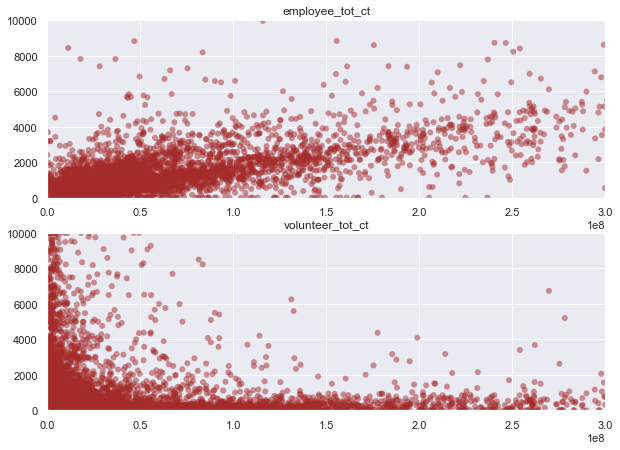

In [216]:
# graph employees against contractor count
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df.loc[:,'employee_tot_ct' : 'volunteer_tot_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    ax = sns.scatterplot(df.salaries_expense_tot_curyr, df[column], color='brown', alpha=.5, edgecolor="none");
    ax.set_ylabel('')    
    ax.set_xlabel('')
    plt.xlim(0, 300000000)
    plt.ylim(0, 10000)

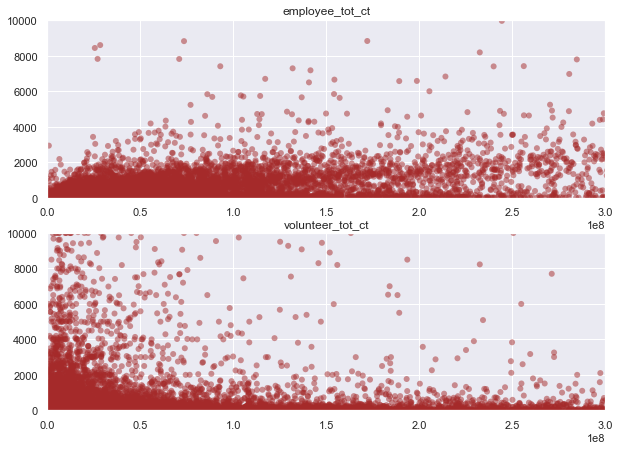

In [217]:
# graph employees against contractor count
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df.loc[:,'employee_tot_ct' : 'volunteer_tot_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    ax = sns.scatterplot(df.gross_receipts, df[column], color='brown', alpha=.5, edgecolor="none");
    ax.set_ylabel('')    
    ax.set_xlabel('')
    plt.xlim(0, 300000000)
    plt.ylim(0, 10000)

As gross receipts increases, beyond 2000 employees the count of employees remains about the same.  Beyond $1M, volunteer count remains about the same.

Some orgs that receive lots of money have few volunteers

#### Financial Visualizations

In [426]:
df.loc[:,'income_tot_unrelated' : 'asset_net_endyr'].columns

Index(['income_tot_unrelated', 'income_net_unrelated',
       'rev_giftsgrants_tot_prioryr', 'rev_prgmservice_prioryr',
       'rev_investmt_prioryr', 'rev_other_prioryr', 'rev_tot_prioryr',
       'grants_expense_tot_prioryr', 'benefits_expense_tot_prioryr',
       'salaries_expense_tot_prioryr', 'fundraiseservfee_expense_tot_prioryr',
       'fundraise_expense_tot_curyr', 'other_expense_tot_prioryr',
       'expense_tot_prioryr', 'rev_less_expense_prioryr', 'asset_tot_beginyr',
       'liability_tot_beginyr', 'asset_net_beginyr',
       'rev_giftsgrants_tot_curyr', 'rev_prgmservice_curyr',
       'rev_investmt_curyr', 'rev_other_curyr', 'rev_tot_curyr',
       'grants_expense_tot_curyr', 'benefits_expense_tot_curyr',
       'salaries_expense_tot_curyr', 'fundraiseservfee_expense_tot_curyr',
       'other_expense_tot_curyr', 'expense_tot_curyr',
       'rev_less_expense_curyr', 'asset_tot_endyr', 'liability_tot_endyr',
       'asset_net_endyr'],
      dtype='object')

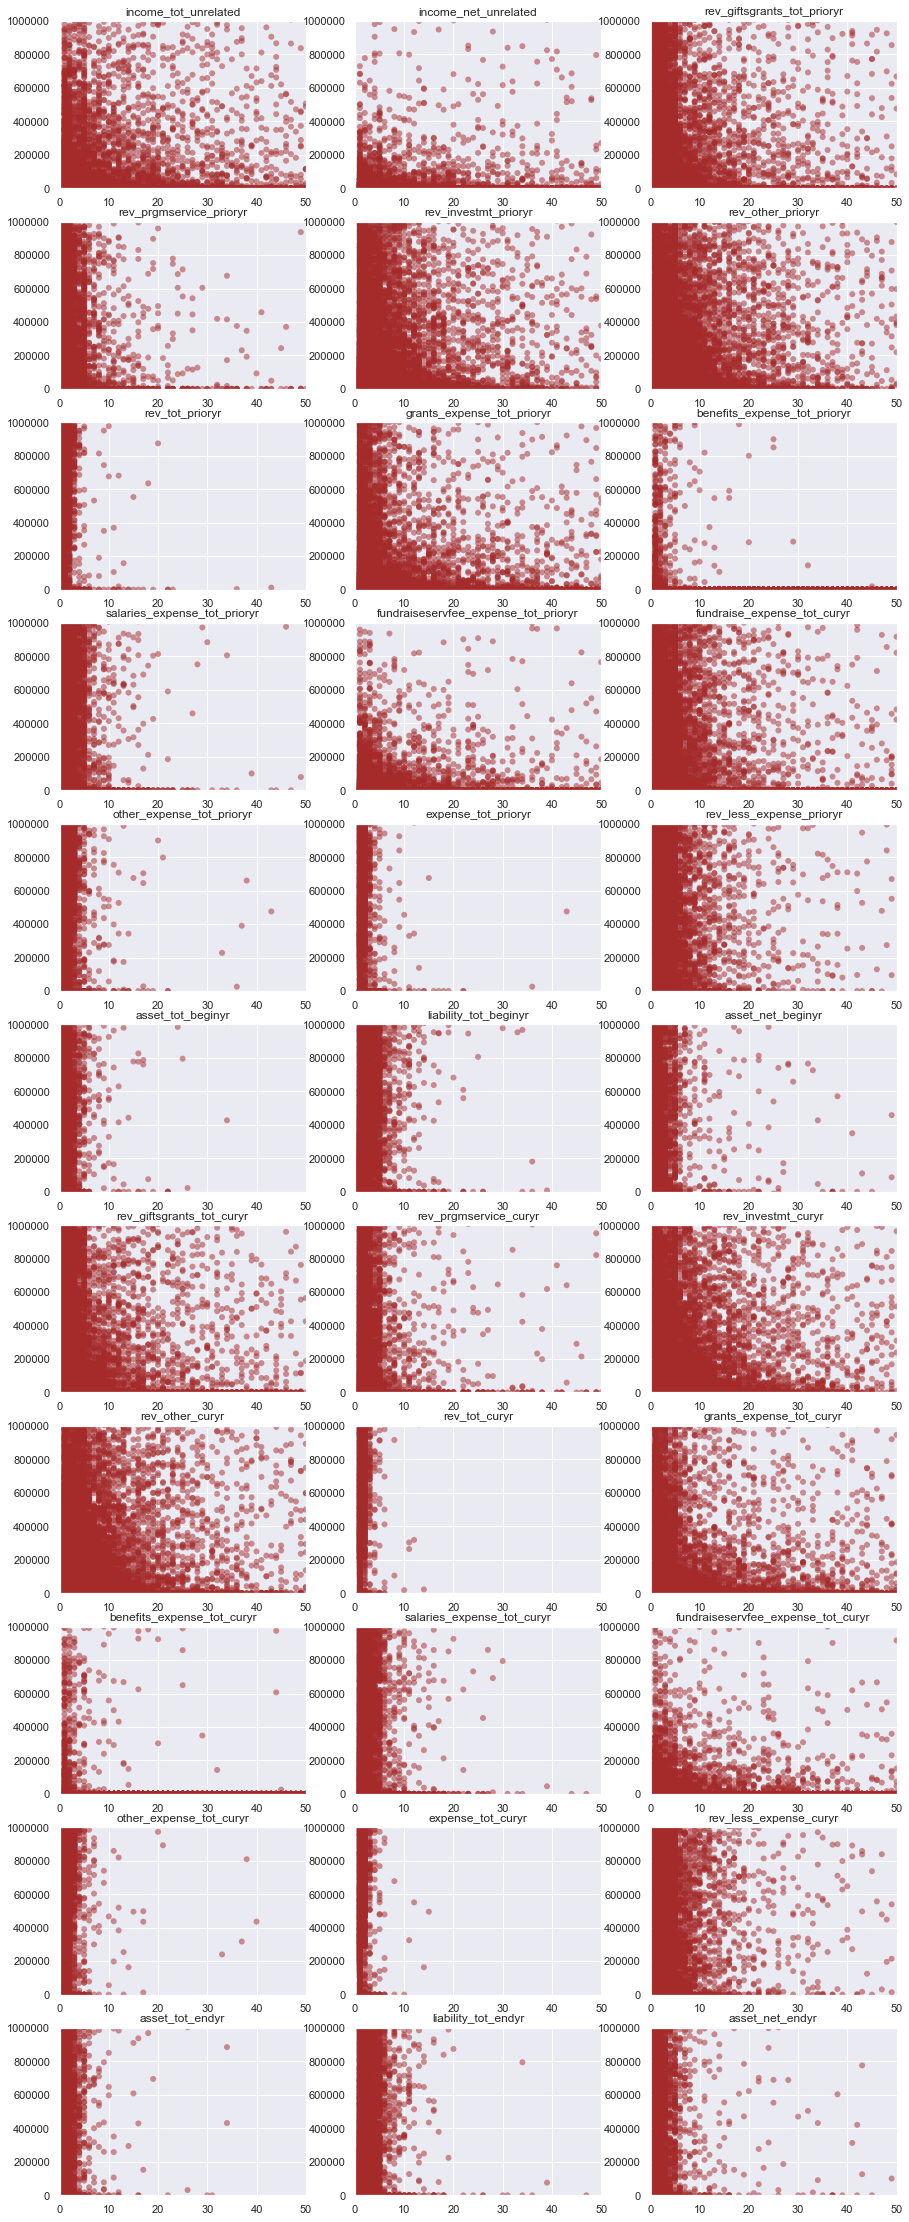

In [225]:
fig = plt.figure(figsize=(15, 40))

for i, column in enumerate(df.loc[:,'income_tot_unrelated' : 'asset_net_endyr'].columns):
    plt.subplot(ceil(len(df.loc[:,'income_tot_unrelated' : 'asset_net_endyr'].columns)/3), 3, i+1)
    plt.title(column)
    plt.scatter(df.contractor_100k_ct, df[column], color='brown', alpha=.5, edgecolor="none")
    plt.xlim(0, 50)
    plt.ylim(0, 1000000);

In [227]:
df.head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,phone,website,address,city,state,zip,org_form_corp,org_form_trust,org_form_association,org_form_other_form,formation_yr,state_legaldomicile,grp_return,exempt_status_501c3,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string,CON_CT_DIV_EMP_VOL_CT
13,10056837,EASTERN MAINE ELECTRIC COOPERATIVE INC,2016-01-01,2016-12-31,2016,+1 (207) 454-7555,www.emec.com,PO Box 425,Calais,ME,046190425,True,False,False,False,1940,ME,no,NaN,12,15549792,11,11,37,0.0,0,0.0,0.0,15540869.0,280449.0,0.0,15821318.0,0.0,352726.0,1774024.0,0.0,0,13694568.0,15821318.0,0.0,39372255.0,26541056.0,12831199.0,0,15214173,335619,0,15549792,0,-242865,1753677,0,14038980,15549792,0,39367859,26785093,12582766,Lucas Tree Experts,PO Box 958,Portland,ME,04104,NaN,Tree Clearing Work,144757.0,Preti Flaherty Beliveau Pachios LLP,PO Box 9546,Portland,ME,04112,NaN,Legal,284923.0,On Target Utility Services,617 Water St,Gardiner,ME,04345,NaN,Utility Construction,526681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010056837_201612,2016v3.0,201722499349300607,NTk1ODY4MDk3ODk3NjYyMDY2OQ,0.081081
17,10079380,CPORT CREDIT UNION,2016-01-01,2016-12-31,2016,+1 (207) 878-6200,WWW.CPORTCU.ORG,PO BOX 777,PORTLAND,ME,04104,True,False,False,False,1931,ME,no,NaN,14,9472036,9,8,81,8.0,52565,-75519.0,0.0,8093378.0,128192.0,162461.0,8384031.0,0.0,850819.0,3076199.0,0.0,0,3456770.0,7383788.0,1000243.0,173898488.0,157544120.0,16354368.0,0,9089872,158726,223438,9472036,0,752626,3404135,0,4052976,8209737,1262299,188534687,170915216,17619471,SYNERGENT,2 LEDGEVIEW DRIVE,WESTBROOK,ME,04092,NaN,CORE PROCESSING AND RELATED SERVICES,806186.0,SYSTEMS ENGINEERING,120 EXCHANGE STREET,PORTLAND,ME,04101,NaN,INFORMATION TECH. SERVICES,171160.0,PM SYSTEMS (ACI WORLDWIDE CORP),99944 COLLECTION CENTER DR,CHICAGO,IL,60693,NaN,ONLINE BANKING PROVIDER,147655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010079380_201612,2016v3.0,201713179349301261,NTAxNDUzNjQ4MzgwNDIzMTg2MA,0.033708
27,10114035,Maine Education Association,2015-09-01,2016-08-31,2016,+1 (207) 622-5866,www.maine.nea.org,35 Community Drive,Augusta,ME,04330,True,False,False,False,1859,ME,no,NaN,5,8503978,21,19,53,200.0,16110,0.0,676851.0,7646167.0,31555.0,0.0,8354573.0,152815.0,0.0,6033969.0,0.0,0,2223320.0,8410104.0,-5

#### 501c Type and Contractor Count Visualizations

(0, 1000)

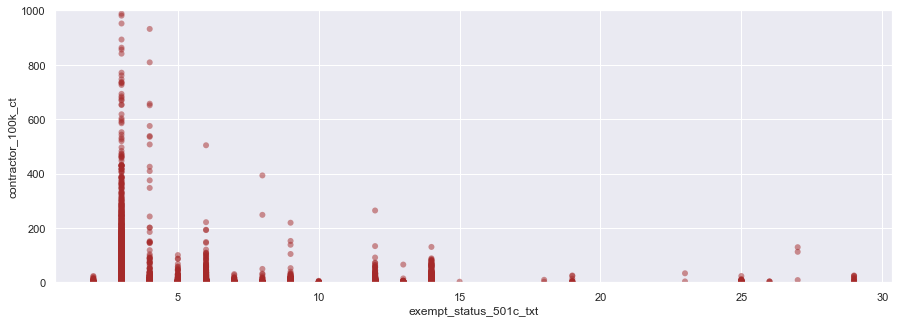

In [233]:
# graph 501c type against feature I created
fig = plt.figure(figsize=(15, 5))

sns.scatterplot(df['exempt_status_501c_txt'], df.contractor_100k_ct, color='brown', alpha=.5, edgecolor="none");
plt.ylim(0, 1000)

###  1. Target variable feature creation - employees & volunteers as a percentage of over $100K contractors
a high ratio could be indicative of low oversight of the process of engaging, reviewing the work of, and paying contractors

In [81]:
# identify columns with employee in them
for c in df.columns:
    if 'vol' in c:
        print(c)       

volunteer_tot_ct


In [150]:
# identify columns with count of vendors
for c in df.columns:
    if '100k_ct' in c:
        print(c)       

contractor_100k_ct


In [245]:
# create feature 

df['CON_CT_DIV_EMP_VOL_CT'] = df['contractor_100k_ct'] / \
                              df[['employee_tot_ct', 'volunteer_tot_ct']].sum(axis=1)

In [247]:
df['CON_CT_DIV_EMP_VOL_CT'].min()

7.904994612746171e-07

In [235]:
df['CON_CT_DIV_EMP_VOL_CT'].max()

inf

In [236]:
# some organizations have no employees or volunteers
# it's not clear to me how these orgs are operating
# I will drop them
df[df['CON_CT_DIV_EMP_VOL_CT'] == np.inf].index

Int64Index([   640,    658,    734,    851,   1020,   1090,   1139,   1247,
              1315,   1333,
            ...
            237403, 237406, 237410, 237411, 237412, 237426, 237428, 237438,
            237439, 237445],
           dtype='int64', length=3056)

In [237]:
# drop exception values
df.drop(df[df['CON_CT_DIV_EMP_VOL_CT'] == np.inf].index, inplace=True)

In [238]:
# how large is my dataset?
df.shape

(27129, 104)

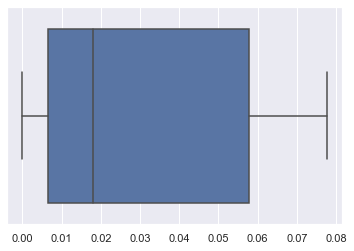

In [248]:
# had to remove outliers just to get it to plot
# otherwise I get an error message
sns.boxplot(winsorize(df['CON_CT_DIV_EMP_VOL_CT'], (0,.2)));

(0, 20)

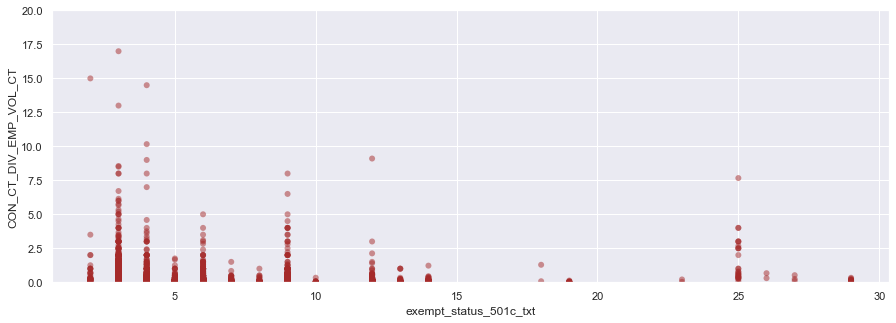

In [243]:
# graph 501c type against feature I created
fig = plt.figure(figsize=(15, 5))

sns.scatterplot(df['exempt_status_501c_txt'], df['CON_CT_DIV_EMP_VOL_CT'], color='brown', alpha=.5, edgecolor="none");
plt.ylim(0, 20)

###  2. Target variable feature creation - mean contractor payment / total current year expense

the larger this is the higher the share of the organizations expenses are made up of contractor payments

In [244]:
# identify columns
for c in df.columns:
    if 'expense_tot' in c:
        print(c)       

grants_expense_tot_prioryr
benefits_expense_tot_prioryr
salaries_expense_tot_prioryr
fundraiseservfee_expense_tot_prioryr
fundraise_expense_tot_curyr
other_expense_tot_prioryr
expense_tot_prioryr
grants_expense_tot_curyr
benefits_expense_tot_curyr
salaries_expense_tot_curyr
fundraiseservfee_expense_tot_curyr
other_expense_tot_curyr
expense_tot_curyr


In [249]:
# some vendors have smaller expenses than vendor payments
# this doesn't seem right
# drop exception values
df.drop(df[df.expense_tot_curyr < df[['amt_paid_contractor_1', 
                                         'amt_paid_contractor_2', 
                                         'amt_paid_contractor_3', 
                                         'amt_paid_contractor_4', 
                                         'amt_paid_contractor_5']].mean(axis=1)].index, inplace=True)

In [250]:
df.shape

(26881, 104)

In [251]:
# divide mean contractor payments by total expenses for the year
# this provides the percent of total expenses that contractor payments make up
df['CON_EXP_DIV_TOT_EXP'] = df[['amt_paid_contractor_1', 
                                         'amt_paid_contractor_2', 
                                         'amt_paid_contractor_3', 
                                         'amt_paid_contractor_4', 
                                         'amt_paid_contractor_5']].mean(axis=1) / df.expense_tot_curyr

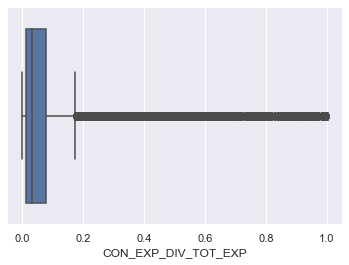

In [252]:
sns.set(style='darkgrid')
sns.boxplot(df['CON_EXP_DIV_TOT_EXP']);

# plt.boxplot(df['CON1_EXP_DIV_TOT_EXP'])

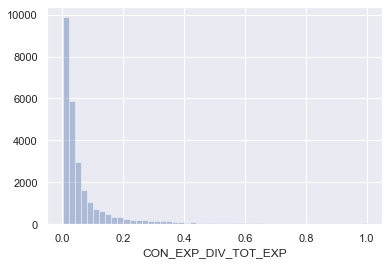

In [253]:
sns.distplot(df['CON_EXP_DIV_TOT_EXP'], kde=False)

In [255]:
# what other 501c types are there?
df['exempt_status_501c_txt'].value_counts()

3     21229
6      2163
12      655
4       623
5       577
9       544
14      512
7       377
8        57
13       56
2        28
25       15
10       14
29       11
19       11
27        3
23        2
26        2
18        2
Name: exempt_status_501c_txt, dtype: int64

### Export cleaned data of orgs with contractors for modeling


In [271]:
df.to_csv('data/990_model_data.csv', index=None, header=True)

### Identify 501c3 orgs with at least one contractor - export to identify mission category of org.
1. write this to CSV and 
1. use to be able to identify categories of orgs in *990_mission_statement* notebook
1. categories should fall within *Religious, Educational, Charitable, Scientific, Literary, Testing for Public Safety, to Foster National or International Amateur Sports Competition, or Prevention of Cruelty to Children or Animals Organizations*

In [349]:
# identify orgs that have at least one contractor
# over 100K and also are 501c3 in type
# write to a CSV file to be able to 
# identify categories of the 501c3s
df[(df['exempt_status.501c3'] == True)
      ].loc[:,'ein'].to_csv('data/ein_orgs_with_contractors.csv', 
       header=True,
       index=False)

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [653]:
df[(df['exempt_status.501c3'] == True)
      ].loc[:,'ein'].shape

(21311,)